In [2]:
using CSV, DataFrames, Dates, Gurobi, JuMP, Statistics, Plots

In [3]:
df = CSV.read("data.csv", DataFrame)
D_t = df[!, "FR_load_forecast_entsoe_transparency"]

println(size(D_t))
println(first(D_t, 5))

df = CSV.read("data.csv", DataFrame)
D_t = df[!, "FR_load_forecast_entsoe_transparency"]

println(size(D_t))
println(first(D_t, 5))
        
file_path = "capacity_pv.csv"
df = CSV.File(file_path; header=true) |> DataFrame
capacity_pv = Array(df)
println(first(capacity_pv, 10))
    
file_path = "capacity_wind.csv"
df = CSV.File(file_path; header=true) |> DataFrame
capacity_wind = Array(df)
println(first(capacity_wind, 10))

(8760,)
[56250.0, 54300.0, 53600.0, 50000.0, 47100.0]
(8760,)
[56250.0, 54300.0, 53600.0, 50000.0, 47100.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.067, 0.218]
[0.12594, 0.123693, 0.124232, 0.13045, 0.140045, 0.136766, 0.129185, 0.135791, 0.152821, 0.14136]


In [4]:
file_path = "Imbalance.csv"
data = CSV.read(file_path, DataFrame)

# The column containing the target data
imbalance_column_name = "Total Imbalance [MWh] - SCA|FR"

# Check if the column is present
if !(imbalance_column_name in names(data))
    error("Column '$imbalance_column_name' not found in the data.")
end

# Extract the "Total Imbalance [MWh] - SCA|FR" data
imbalance_data = data[!, imbalance_column_name]

# Convert non-numeric values to missing values
function to_int(value)
    try
        return parse(Int, value)
    catch
        return missing
    end
end

# Apply the conversion function and filter out missing values
imbalance = filter(!ismissing, to_int.(imbalance_data))
sorted_data = sort(vec(sum(reshape(imbalance, 2, :), dims=1)))



8606-element Vector{Union{Missing, Int64}}:
   15
   17
   19
   22
   22
   22
   23
   25
   25
   25
   26
   26
   29
    ⋮
 3539
 3585
 3715
 3723
 3737
 3797
 3814
 3820
 3923
 4421
 4543
 5197

In [5]:

function compute_lolp(reserve, sorted_imbalance)
    # Probability of an imbalance higher than the given reserve
    return mean(sorted_imbalance .> reserve)
end


discretization_step = 20
reserve_range = minimum(sorted_data):discretization_step:maximum(sorted_data)

lolp_values = [compute_lolp(R, sorted_data) for R in reserve_range]

VOLL = 5000

ordc_values = lolp_values .* VOLL

sorted_data = sort(vec(sum(reshape(imbalance, 2, :), dims=1)))



8606-element Vector{Union{Missing, Int64}}:
   15
   17
   19
   22
   22
   22
   23
   25
   25
   25
   26
   26
   29
    ⋮
 3539
 3585
 3715
 3723
 3737
 3797
 3814
 3820
 3923
 4421
 4543
 5197

In [6]:

reserve_range_shift = [R - minimum(sorted_data) for R in reserve_range]
reserve_size = length(reserve_range_shift)

U_ORDC= Float64[]
for R in reserve_range_shift
    # Define the interval for the current reserve R
    intervals = collect(0:discretization_step:R)
    
    # Calculate the area under the curve for the current reserve R using rectangles method
    area = 0.0
    for i in 1:length(intervals)-1
        height = ordc_values[findfirst(x -> x ≥ intervals[i], reserve_range_shift)]
        width = intervals[i+1] - intervals[i]
        area += height * width
    end
    push!(U_ORDC, area)
end

In [7]:
# Constants and Data
T = 8760
lambda = 5000  
cost_of_debt = 0.04
cost_of_equity = 0.07
corporate_tax = 0.30
economic_life = 20
carbon_tax = 50 

capacity = Dict(
    "Coal" => 1,
    "CCGT" => 1,
    "OCGT" => 1,
    "Onshore Wind" => capacity_wind,
    "Offshore Wind" => capacity_wind,
    "PV" => capacity_pv
)

# Technologies data
technologies = Dict(
    "Coal" => (capex=2000*1000, om=0.03, debt_ratio=0.62, heat_rate=2.4, EA=175.2252157*1000, price =5, C=12, emissions=1.4),
    "CCGT" => (capex=950*1000, om=0.03, debt_ratio=0.56, heat_rate=1.62, EA=85.60445144*1000, price =30, C=48.6, emissions=0.5),
    "OCGT" => (capex=700*1000, om=0.03, debt_ratio=0.6, heat_rate=2.5, EA=61.91153839*1000, price =30, C=75, emissions=0.6),
    "Onshore Wind" => (capex=700*1000, om=0.03, debt_ratio=0.7, heat_rate=0, EA=58.99797384*1000, price =0, C=0, emissions=0.0),
    "Offshore Wind" => (capex=1300*1000, om=0.03, debt_ratio=0.7, heat_rate=0, EA=109.5676657*1000, price =0, C=0, emissions=0.0),
    "PV" => (capex=400*1000, om=0.03, debt_ratio=0.8, heat_rate=0, EA=32.04823387*1000, price =0, C=0, emissions=0.0)
)

technologies_t = Dict(
    "Coal" => (capex=2000*1000, om=0.03, debt_ratio=0.62, heat_rate=2.4, EA=175.2252157*1000, price =5, C=12, emissions=1.4),
    "CCGT" => (capex=950*1000, om=0.03, debt_ratio=0.56, heat_rate=1.62, EA=85.60445144*1000, price =30, C=48.6, emissions=0.5),
    "OCGT" => (capex=700*1000, om=0.03, debt_ratio=0.6, heat_rate=2.5, EA=61.91153839*1000, price =30, C=75, emissions=0.6)
)

technologies_r = Dict(
    "Onshore Wind" => (capex=700*1000, om=0.03, debt_ratio=0.7, heat_rate=0, EA=58.99797384*1000, price =0, C=0, emissions=0.0),
    "Offshore Wind" => (capex=1300*1000, om=0.03, debt_ratio=0.7, heat_rate=0, EA=109.5676657*1000, price =0, C=0, emissions=0.0),
    "PV" => (capex=400*1000, om=0.03, debt_ratio=0.8, heat_rate=0, EA=32.04823387*1000, price =0, C=0, emissions=0.0)
)

#Battery data
F_b=6*1000/20
A_b=1.620627574*1000
eta=0.9
capex_b= 25000

25000

In [31]:
T = 8760
model = Model(Gurobi.Optimizer)


@variable(model, k[g in keys(technologies)] >= 0)  # Installed capacity
@variable(model, p[g in keys(technologies), t=1:T] >= 0)  # Hourly production
@variable(model, r[g in keys(technologies_t), t=1:T] >= 0)  # Hourly reserve # seulement pour les thermiques
# @variable(model, R[t=1:T]>=0) #Total Hourly Reserve
@variable(model, 1>=z[t=1:T, i=1:reserve_size]>=0)  # Binary variable for reserve selection
@variable(model, d[t=1:T] >=0)
#For Battery
@variable(model, k_b>=0 ) 
@variable(model, e[1:T] >= 0)
@variable(model, p_in[1:T] >=0)
@variable(model, p_out[1:T] >=0)



# Define the objective function
@objective(model, Min,
    sum((technologies[g].om * technologies[g].capex + technologies[g].EA) * k[g] +
        sum(technologies[g].C * p[g, t] for t in 1:T) for g in keys(technologies)) +
    (A_b + F_b) * k_b -
    sum(lambda * d[t] for t in 1:T) +
    carbon_tax * sum(technologies[g].emissions * sum(p[g, t] for t in 1:T) for g in keys(technologies)) -
    sum(U_ORDC[i] * z[t, i] for t in 1:T, i = 1:reserve_size)
)
    
@constraint(model, [t in 1:T], d[t]<=D_t[t])
@constraint(model, price[t in 1:T], -d[t] + p_out[t] - p_in[t]  + sum( p[g,t] for g in keys(technologies))==0)

@constraint(model, [t in 1:T], e[t]<= 4*k_b)
@constraint(model, [t in 1:T], p_in[t]<=k_b)
@constraint(model, [t in 1:T], p_out[t]<=k_b)
@constraint(model,  e[1]==0)
@constraint(model, [t in 2:T], e[t]== e[t-1] + 1*(sqrt(eta)* p_in[t-1] - 1/sqrt(eta) * p_out[t-1]))

for g in ["Coal", "CCGT", "OCGT"]
    @constraint(model, [t in 1:T], p[g, t] + r[g, t] <= k[g])
end
for t in 1:T
    @constraint(model, p["Onshore Wind", t] <= capacity_wind[t]*k["Onshore Wind"])
    @constraint(model, p["Offshore Wind", t] <= capacity_wind[t]*k["Offshore Wind"])
    @constraint(model, p["PV", t] <= capacity_pv[t]*k["PV"])
end

#reserve constraints
@constraint(model, price_r[t in 1:T], sum(r[g,t] for g in keys(technologies_t))==sum(reserve_range_shift[i] * z[t, i] for i in 1:reserve_size))
# Ensure exactly one `z[t, i]` is 1 for each `t`
@constraint(model, [t = 1:T], sum(z[t, i] for i = 1:reserve_size) == 1)



optimize!(model)

print("Variables value, k:",value.(k))
print("Variables value, k_b:",value.(k_b))
# print("Variables value, d:",value.(d))
print("Objective value: ", objective_value(model))
print(keys(technologies))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-31
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 122640 rows, 2391487 columns and 4875211 nonzeros
Model fingerprint: 0x17f8af68
Coefficient statistics:
  Matrix range     [1e-03, 5e+03]
  Objective range  [7e+01, 4e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 12869 rows and 12869 columns
Presolve time: 5.33s
Presolved: 109771 rows, 2378618 columns, 4849472 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 7
 AA' NZ     : 2.283e+05
 Factor NZ  : 1.640e+06 (roughly 1.0 GB of memory)
 Factor Ops : 2.850e+07 (less than 1 second per iteration)
 Threads    : 3

            

## Results

In [16]:
println("\n")
println("Point I")
println("Optimal capacities (MW):")
total_production = 0
production_by_tech = Dict(g => 0.0 for g in keys(technologies))
for g in keys(technologies)
    cap = value(k[g])  # This ensures 'cap' remains a floating-point number
    println("$(g): $(cap) MW")
    for t in 1:T
        production_by_tech[g] += value(p[g, t])  # Accumulate as floating-point values
        total_production += value(p[g, t])  # Keep total production as floating-point
    end
end
    cap = value(k_b)  # This ensures 'cap' remains a floating-point number
    println("Battery: $(cap) MW")

println("\n")

println("Point II")
println("Share of each technology in effective production:")
for g in keys(technologies)
    share = production_by_tech[g] / total_production
    println("$(g): $(share * 100) %")
end
println("\n")



Point I
Optimal capacities (MW):
Coal: 0.0 MW
CCGT: 14078.949485106772 MW
Offshore Wind: 0.0 MW
OCGT: 4919.985820906103 MW
PV: 44519.63238585983 MW
Onshore Wind: 193986.60363161075 MW
Battery: 1.139693455367199e6 MW


Point II
Share of each technology in effective production:
Coal: 0.0 %
CCGT: 5.668374699401652 %
Offshore Wind: 0.0 %
OCGT: 0.38745901043797665 %
PV: 11.819323518613722 %
Onshore Wind: 82.12484277154715 %




<div class="alert alert-block alert-info">
Question 19
</div>

In [30]:
hours_per_year = 8760
model = Model(Gurobi.Optimizer)


@variable(model, k[g in keys(technologies)] >= 0)  # Installed capacity
@variable(model, p[g in keys(technologies), t=1:T] >= 0)  # Hourly production
@variable(model, d[t=1:T] >=0)
#For Battery
@variable(model, k_b>=0 ) 
@variable(model, e[1:T] >= 0)
@variable(model, p_in[1:T] >=0)
@variable(model, p_out[1:T] >=0)


@objective(model, Min, sum((technologies[g].om * technologies[g].capex + technologies[g].EA )*k[g] + sum(technologies[g].C*p[g,t]  for t in 1:T) for g in keys(technologies))+ (A_b + F_b)* k_b - sum( lambda * d[t] for t in 1:T)
+ carbon_tax * sum(technologies[g].emissions * sum(p[g, t] for t in 1:hours_per_year) for g in keys(technologies)))

@constraint(model, [ g in keys(technologies), t in 1:T], p[g,t] <= k[g])
@constraint(model, [t in 1:T], d[t]<=D_t[t])
@constraint(model, price2[t in 1:T], -d[t] + p_out[t] - p_in[t]  + sum( p[g,t] for g in keys(technologies))==0)
@constraint(model, [t in 1:T], e[t]<= 4*k_b)
@constraint(model, [t in 1:T], p_in[t]<=k_b)
@constraint(model, [t in 1:T], p_out[t]<=k_b)
@constraint(model,  e[1]==0)
@constraint(model, [t in 2:T], e[t]== e[t-1] + 1*(sqrt(eta)* p_in[t-1] - 1/sqrt(eta) * p_out[t-1]))
for g in ["Coal", "CCGT", "OCGT"]
    @constraint(model, [t in 1:T], p[g, t] <= k[g])
end
for t in 1:T
    @constraint(model, p["Onshore Wind", t] <= capacity_wind[t]*k["Onshore Wind"])
    @constraint(model, p["Offshore Wind", t] <= capacity_wind[t]*k["Offshore Wind"])
    @constraint(model, p["PV", t] <= capacity_pv[t]*k["PV"])
end

optimize!(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-31
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 157680 rows, 87607 columns and 381331 nonzeros
Model fingerprint: 0xe856f8e3
Coefficient statistics:
  Matrix range     [1e-03, 4e+00]
  Objective range  [7e+01, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+04, 1e+05]
Presolve removed 43255 rows and 4109 columns
Presolve time: 0.66s
Presolved: 114425 rows, 83498 columns, 303580 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 7
 AA' NZ     : 2.598e+05
 Factor NZ  : 1.724e+06 (roughly 100 MB of memory)
 Factor Ops : 2.766e+07 (less than 1 second per iteration)
 Threads    : 3

                  O

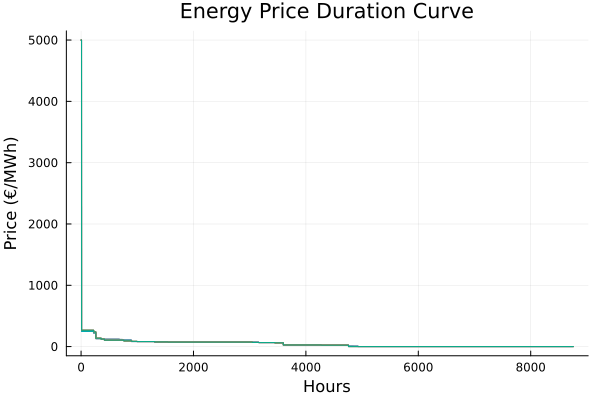

In [57]:
prices = [JuMP.dual(price2[i]) for i in 1:hours_per_year]

# Sorting and plotting
using Plots
sorted_prices = sort(prices, rev=true)
plot!(sorted_prices, title="Energy Price Duration Curve", xlabel="Hours", ylabel="Price (€/MWh)", legend=false)

In [74]:
dual_prices1 = [dual(price[t]) for t in 1:T]

dual_prices2 = [dual(price2[t]) for t in 1:T]

sorted_dual_prices1 = sort(dual_prices1, rev=true)
sorted_dual_prices2 = sort(dual_prices2, rev=true)

plot(sorted_dual_prices1, label="With ORDC", title="Energy Price Duration Curves", xlabel="Hours", ylabel="Price (€ / MWh)",legend=true)
plot!(sorted_dual_prices2, label="Without ORDC")

savefig("energy duration curve.pdf")

"c:\\Users\\accol\\OneDrive\\Documents\\MAP2\\Energie economic\\energy duration curve.pdf"

<div class="alert alert-block alert-info">
Question 20
</div>

In [82]:
dual_prices_2 = [dual(price2[t]) for t in 1:T]
dual_prices_1 = [dual(price[t]) for t in 1:T]

total_investment_cost = sum(technologies[g].capex * value(k[g]) for g in keys(technologies)) + capex_b * value(k_b)

hourly_profit_ordc = [
    dual_prices_1[t] * value(p["Onshore Wind", t]) - (technologies["Onshore Wind"].om + technologies["Onshore Wind"].C * value(p["Onshore Wind", t]))
    for t in 1:T
]

hourly_profit_no_ordc = [
    dual_prices_2[t] * value(p["Onshore Wind", t]) - (technologies["Onshore Wind"].om + technologies["Onshore Wind"].C * value(p["Onshore Wind", t]))
    for t in 1:T
]

annual_profit_ocgt = sum(hourly_profit_ocgt) - total_investment_cost
annual_profit_ccgt = sum(hourly_profit_ccgt) - total_investment_cost

plot(hourly_profit_ordc, label="with ORDC", title="Hourly Profit Stream for Onshore wind", xlabel="Hours", ylabel="Profit (€)")
plot!(hourly_profit_no_ordc, label="without ORDC",linestyle=:dash, dash=[2, 2])

savefig("profit duration curve.pdf")


"c:\\Users\\accol\\OneDrive\\Documents\\MAP2\\Energie economic\\profit duration curve.pdf"

In [42]:
prices_r=[JuMP.dual(price_r[i]) for i in 1:T]
println(prices_r)

[4895.0, 4895.0, 4895.0, 4895.0, 4895.0, 4895.0, 4895.0, 4895.0, 11.342849083721223, 11.34284908372122, 11.342849083721234, 11.34284908372122, 11.34284908372122, 11.342849083721234, 11.34284908372122, 11.34284908372122, 11.342849083721234, 11.34284908372122, 11.34284908372122, 11.342849083721234, 11.34284908372122, 11.34284908372122, 11.342849083721234, 11.34284908372122, 11.34284908372122, 11.342849083721234, 11.34284908372122, 11.34284908372122, 11.342849083721234, 11.34284908372122, 11.34284908372122, 11.34284908372122, 11.34284908372122, 11.342849083721234, 11.34284908372122, 11.34284908372122, 11.342849083721234, 11.34284908372122, 24.269832315245814, 11.342849083721234, 11.34284908372122, 24.269832315245814, 24.269832315245814, 24.269832315245814, 24.269832315245814, 24.269832315245814, 24.269832315245814, 24.269832315245814, 24.269832315245814, 24.269832315245814, 24.269832315245814, 11.342849083721234, 11.342849083721234, 11.342849083721234, 11.342849083721234, 11.3428490837212

In [51]:
prices=[JuMP.dual(price[i]) for i in 1:T]
println(prices)


[5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 5000.0, 116.34284908372122, 116.34284908372122, 116.34284908372123, 116.34284908372122, 116.34284908372122, 116.34284908372123, 116.34284908372122, 116.34284908372122, 116.34284908372123, 116.34284908372122, 116.34284908372122, 116.34284908372123, 116.34284908372122, 116.34284908372122, 116.34284908372123, 116.34284908372122, 116.34284908372122, 116.34284908372123, 116.34284908372122, 116.34284908372122, 116.34284908372123, 116.34284908372122, 116.34284908372122, 116.34284908372122, 116.34284908372122, 116.34284908372123, 116.34284908372122, 116.34284908372122, 116.34284908372123, 116.34284908372122, 129.26983231524582, 116.34284908372123, 116.34284908372122, 129.26983231524582, 129.26983231524582, 129.26983231524582, 129.26983231524582, 129.26983231524582, 129.26983231524582, 129.26983231524582, 129.26983231524582, 129.26983231524582, 129.26983231524582, 116.34284908372123, 116.34284908372123, 116.34284908372123, 116.34284908372